This notebook change the length of all wav files preprocessed to 22kHz 

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import numpy as np 
from analysis import quantize
import os 

In [2]:
filepath = '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/'
listfiles = os.listdir(filepath)
listnpz = []
for c in listfiles:
    if c[-3:] == 'npz':
        listnpz.append(os.path.join(filepath,c))

In [7]:
listnpz


['/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess3.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess5_2.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess5_1.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess2.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess4_1.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess6.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess4_3.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_sess4_2.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_perf1.npz',
 '/home/brain/Desktop/BrainSongs/audiosummary_private/christopherocher/caroleeg_perf2.npz']

In [34]:
import soundfile as sf
def load(filepath):
    sound, sr = sf.read(filepath,dtype ='float32')   
    return sound,sr

In [40]:

def cut(filepath,addnoise = True):
    resultdir = os.path.join('data_clean')
    os.makedirs(resultdir,exist_ok=True)
    # audio 22kHz, mono
    audiopath = '/home/brain/Desktop/BrainSongs/audiosummary_private/audio22k/'
    for curnpz in listnpz:
        focus = np.load(curnpz)['focus']
        
        subjtime = np.load(curnpz)['subjtime']
        #Quantization
        focus_q = quantize(focus,res=1,delaytime=0) 
        subt_q = quantize(subjtime,res=1,delaytime=1)

        maxtime = min(focus_q.shape[0],subt_q.shape[0])

        if addnoise:
            focus_q[:maxtime,1] += np.random.rand(maxtime)
            subt_q[:maxtime,1] += np.random.rand(maxtime)
        
        ## name of audiofile
        name = curnpz.split('/')[7][:-4] 
        audio,sr = load("{}{}_.wav".format(audiopath,name))
        print("Maxtime : {}s, audio.shape : {}s".format(maxtime,audio.shape[0]/sr))
        if audio.shape[0] > maxtime*sr:
            audio = audio[:maxtime*sr]        
        #save
        sf.write('{}/{}.wav'.format(resultdir,name), audio, sr)
        
        print("audio ok, new shape : {}s".format(audio.shape[0]/sr))

In [41]:
#quantize and save data
cut(filepath)

Maxtime : 1701s, audio.shape : 1766.7273015873016s
audio ok, new shape : 1701.0s
npz ok
Maxtime : 895s, audio.shape : 951.2727437641723s
audio ok, new shape : 895.0s
npz ok
Maxtime : 602s, audio.shape : 698.1818594104309s
audio ok, new shape : 602.0s
npz ok
Maxtime : 907s, audio.shape : 977.4545578231292s
audio ok, new shape : 907.0s
npz ok
Maxtime : 543s, audio.shape : 558.5454875283447s
audio ok, new shape : 543.0s
npz ok
Maxtime : 1724s, audio.shape : 1741.0909297052153s
audio ok, new shape : 1724.0s
npz ok
Maxtime : 453s, audio.shape : 558.5454875283447s
audio ok, new shape : 453.0s
npz ok
Maxtime : 594s, audio.shape : 558.5454875283447s
audio ok, new shape : 558.5454875283447s
npz ok
Maxtime : 789s, audio.shape : 855.2727437641723s
audio ok, new shape : 789.0s
npz ok
Maxtime : 1048s, audio.shape : 1077.818185941043s
audio ok, new shape : 1048.0s
npz ok


In [42]:
def get_values():
    to_time = {}    
    with open('/home/brain/Desktop/BrainSongs/audiosummary_private/soundnet/relation_layer_seconds.txt', 'r') as reader:
        for i in reader:
            key,m,b = i.split()
            if key != 'name_layer':
                to_time[key] = [float(m),float(b)]
    return to_time

In [48]:
#change resolution to conv7 and align data from cluster
def change_to_res_audio(name_layer,addnoise = True):
    resultdir = os.path.join('data_clean')
    os.makedirs(resultdir,exist_ok=True)
  
    #find resolution
    cursr = 22050
    m,b = get_values()[name_layer] #get slope (m) and interception (b) for a given layer
    res = (1/m) #separation in time
    
    #path to data clusters
    cluster_path = '/home/brain/Desktop/BrainSongs/audiosummary_private/resultsv2/'
   
    for curnpz in listnpz:
        focus = np.load(curnpz)['focus']
        
        subjtime = np.load(curnpz)['subjtime']
        #Quantization
        focus_q = quantize(focus,res=res,delaytime=0) 
        subt_q = quantize(subjtime,res=res,delaytime=1)

        #find the min include vector of clustering
        ## name of audiofile
        name = curnpz.split('/')[7][:-4]         
        labels = np.load("{}{}/features_conv_v27.npz".format(cluster_path,name))['labels']
        print(focus_q.shape[0],subt_q.shape[0],labels.shape[0])
        maxtime = min(focus_q.shape[0],subt_q.shape[0],labels.shape[0])

        if addnoise:
            focus_q[:maxtime,1] += np.random.rand(maxtime)
            subt_q[:maxtime,1] += np.random.rand(maxtime)
        
       
        print("File {}, length {}, res {:.2f}".format(name,maxtime,res))
        np.savez_compressed("{}/{}.npz".format(resultdir,name),
                            focus = focus_q[:maxtime],
                            subjtime = subt_q[:maxtime],
                            labels = labels[:maxtime])
        print("npz saved in data clean : focus, subjtime and labels ")

In [49]:
change_to_res_audio('conv7')

1171 1139 1146
File caroleeg_sess3, length 1139, res 1.49
npz saved in data clean : focus, subjtime and labels 
599 599 603
File caroleeg_sess5_2, length 599, res 1.49
npz saved in data clean : focus, subjtime and labels 
403 403 406
File caroleeg_sess5_1, length 403, res 1.49
npz saved in data clean : focus, subjtime and labels 
607 607 611
File caroleeg_sess2, length 607, res 1.49
npz saved in data clean : focus, subjtime and labels 
363 363 367
File caroleeg_sess4_1, length 363, res 1.49
npz saved in data clean : focus, subjtime and labels 
1154 1154 1161
File caroleeg_sess6, length 1154, res 1.49
npz saved in data clean : focus, subjtime and labels 
303 303 306
File caroleeg_sess4_3, length 303, res 1.49
npz saved in data clean : focus, subjtime and labels 
397 397 377
File caroleeg_sess4_2, length 377, res 1.49
npz saved in data clean : focus, subjtime and labels 
528 528 532
File caroleeg_perf1, length 528, res 1.49
npz saved in data clean : focus, subjtime and labels 
701 701 70

In [50]:
d = np.load('./data_clean/caroleeg_perf1.npz')

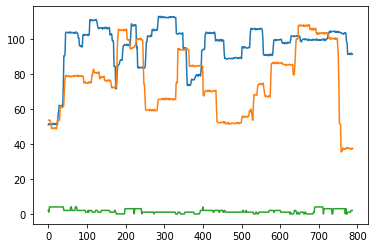

In [53]:
plt.plot(d['focus'][:,0],d['focus'][:,1])
plt.plot(d['subjtime'][:,0],d['subjtime'][:,1])
plt.plot(d['labels'][:,0],d['labels'][:,1])
plt.show()